## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [219]:
import pandas as pd
import numpy as np
import seaborn as sns
import re, nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [220]:
df = pd.read_csv("data/train.csv")
toydf = df.head()


#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

In [221]:
df.head(20)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


### Exploration

0    255027
1    149263
Name: is_duplicate, dtype: int64


<AxesSubplot:>

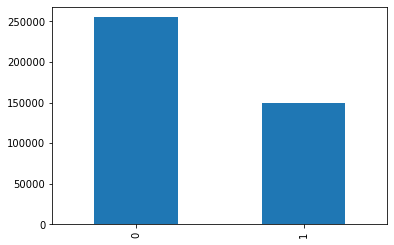

In [222]:
# Let's see how many questions are labelled as the same
print(df['is_duplicate'].value_counts())
import matplotlib.pyplot as plt
df['is_duplicate'].value_counts().plot(kind='bar')

In [223]:
# size of the dataset
df.shape


(404290, 6)

In [224]:
# Are questions all unique or are there repeats?
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique = len(np.unique(qids))
duplicates = np.sum(qids.value_counts() > 1)

print ('Total Questions: {}'.format(unique))
print ('Duplicate Questions: {} ({}%)'.format(duplicates,round(duplicates/unique*100,2)))
print ('Max Repetition: {}'.format(max(qids.value_counts()))) 

Total Questions: 537933
Duplicate Questions: 111780 (20.78%)
Max Repetition: 157


In [225]:
# Quick function to get the number of words in a string
def count_words(column):
    word_count = column.str.split().str.len()
    return word_count

In [226]:
# Add columns with word counts for the questions
df['q1_word_count'] = count_words(df['question1'])
df['q2_word_count'] = count_words(df['question2'])

In [227]:
# Find absolute difference for columns
def abs_diff(column1,column2):
    abs_d = abs(column1 - column2)
    return abs_d

In [228]:
# Find the absolute difference for the word count - that way if I want to run a linear regression,
# we can test the hypothesis that unrelated questions will have a bigger difference in word counts
df['word_count_diff'] = abs_diff(df['q1_word_count'],df['q2_word_count'])

[(0.0, 50.0)]

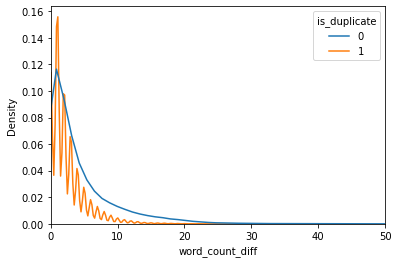

In [229]:
# Huh. I have no idea what this means, but I think this could be interesting. 
# Not sure why it looks like duplicate questions have some sort of periodic wave
fig = sns.kdeplot(data=df, x="word_count_diff", hue="is_duplicate")
fig.set(xlim=(0, 50))

# If I had more time, I would test this further. But for now I will assume that keeping these columns is going
# to help the model.



In [230]:
df.isnull().sum()
df.dropna()

,id,qid1,qid2,question1,question2,is_duplicate,q1_word_count,q2_word_count,word_count_diff
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14.0,12.0,2.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,8.0,13.0,5.0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,14.0,10.0,4.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,11.0,9.0,2.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,13.0,7.0,6.0
...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,14.0,13.0,1.0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,8.0,9.0,1.0
404287,404287,537928,537929,What is one coin?,What's this coin?,0,4.0,3.0,1.0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,17.0,25.0,8.0


### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [231]:
# create a list of tokens 
# I would have liked to spellcheck, but it takes too long - my computer can't handle it. In theory it works.

from textblob import TextBlob
def text_to_word_list(column):
    """This function takes a column from a dataframe, assuming that the data in the column is a string:
    1) converts to lower case
    2) removes with punctuation
    3) turns contractions to full words
    4) Spellcheck
    5) splits the data into a list of tokens
      
    """
    tokens = column
    tokens = column.fillna("").astype('string') 
    tokens = tokens.str.lower()
    tokens = tokens.apply(lambda x: re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", ' ',x))
    tokens = tokens.apply(lambda x: re.sub(r"what's", "what is ",x))
    tokens = tokens.apply(lambda x: re.sub(r"\'s", " ",x))
    tokens = tokens.apply(lambda x: re.sub(r"\'ve", " have ",x))
    tokens = tokens.apply(lambda x: re.sub(r"can't", "cannot ",x))
    tokens = tokens.apply(lambda x: re.sub(r"won't", "will not ",x))
    tokens = tokens.apply(lambda x: re.sub(r"n't", " not ", x))
    tokens = tokens.apply(lambda x: re.sub(r"i'm", "i am ", x))
    tokens = tokens.apply(lambda x: re.sub(r"\'re", " are ", x))
    tokens = tokens.apply(lambda x: re.sub(r"\'d", " would ", x))
    tokens = tokens.apply(lambda x: re.sub(r"\'ll", " will ", x))
    tokens = tokens.apply(lambda x: re.sub(r",", " ",x))
    tokens = tokens.apply(lambda x: re.sub(r"\.", " ", x))
    tokens = tokens.apply(lambda x: re.sub(r"!", " ", x))
    tokens = tokens.apply(lambda x: re.sub(r"\/", " ", x))
    tokens = tokens.apply(lambda x: re.sub(r"\^", "", x))
    tokens = tokens.apply(lambda x: re.sub(r"\+", "", x))
    tokens = tokens.apply(lambda x: re.sub(r"\-", "", x))
    tokens = tokens.apply(lambda x: re.sub(r"\=", "", x))
    tokens = tokens.apply(lambda x: re.sub(r"'", " ", x))
    tokens = tokens.apply(lambda x: re.sub(r":", " : ", x))
    tokens = tokens.apply(lambda x: re.sub(r"(\d+)(k)", r"\g<1>000", x))
    tokens = tokens.apply(lambda x: re.sub(r" e g ", " eg ", x))
    tokens = tokens.apply(lambda x: re.sub(r" b g ", " bg ", x))
    tokens = tokens.apply(lambda x: re.sub(r" u s ", " american ", x))
    tokens = tokens.apply(lambda x: re.sub(r"\0s", "0", x))
    tokens = tokens.apply(lambda x: re.sub(r" 9 11 ", "911", x))
    tokens = tokens.apply(lambda x: re.sub(r"e - mail", "email", x))
    tokens = tokens.apply(lambda x: re.sub(r"j k", "jk", x))
    tokens = tokens.apply(lambda x: re.sub(r"\s{2,}", " ", x))
    tokens = tokens.apply(lambda x: re.sub(r'[0-9]', " ", x))
    tokens = tokens.apply(lambda x: re.sub(r'\b\d+\b', '', x))
    
    
    
    # spellcheck
    # tokens = tokens.apply(lambda x: ''.join(TextBlob(x).correct()))

    tokens = tokens.str.split()

    return tokens

In [232]:
# Add columns that contain tokens
df['q1tokens'] = text_to_word_list(df['question1'])
df['q2tokens'] = text_to_word_list(df['question2'])

In [233]:
# stop word cleaning function
def stop_word(column, keep_list = []):
    """removes stopwrods from column, but keeps the words in the keep_word list"""

    keep_words = keep_list
    stop = set(stopwords.words('english'))
    for word in keep_words:
        stop.remove(word)
    text = [word for word in column if word not in stop]
    return text
        
    # tokens = column.apply(lambda row: str(row.split(' '))- set(stop))
    return tokens

In [234]:
wh_list = [     'who', 
                'what', 
                'when', 
                'why', 
                'how', 
                'which', 
                'where', 
                'whom',
]

aux_list = [    'is',
                'are',
                'was',
                'were',
                'be',
                'been',
                'being',
                'have',
                'has',
                'had',
                'having',
                'do',
                'does',
                'did',
                'doing',
                'no',
                'not',
                'can',
                'will',
    ]

In [235]:
keep = wh_list + aux_list
df['q1content'] = df['q1tokens'].apply(lambda x: stop_word(x,keep))
df['q2content'] = df['q2tokens'].apply(lambda x: stop_word(x,keep))

In [236]:
# create a function to lemmatize the text
def lemmatize_text(column):
    """Takes a column and applies the lemmatizer"""
    lemmatizer = WordNetLemmatizer()
    tokens = column.apply(lambda row: list(list(map(lemmatizer.lemmatize,y)) for y in row))
    return column





In [237]:
df1 = df.head(1)
df1['q1content'] = lemmatize_text(df1['q1content'])
tokens = []
for word in df1['q1content']:
    print(word[0])

what


C:\Users\HP\AppData\Local\Temp\ipykernel_20472\1439655724.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['q1content'] = lemmatize_text(df1['q1content'])


In [238]:
df['q1content'] = lemmatize_text(df['q1content'])
df['q2content'] = lemmatize_text(df['q2content'])

In [239]:
# #create train and test datasets
# training = df[:int((len(df)/100)*80)] #80%
# testing = df[int((len(df)/100)*80):] #20%

In [240]:
# training.to_csv("data/training.csv")

In [241]:
# testing.to_csv("data/testing.csv")

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [242]:
# 1) keep the word counts and abs difference from the EDA.

# 2) starts with same word - this is a worse approximation of the combination of 3 and 4. 
# It's just been used in different attempts of this problem

# 3) has the same question word (e.g. what, how,)

# 4) has the same auxiliary verb (e.g. is, can, do) 
#   - as a syntactician I think this is crucial, but missing from other attempts

# 5) number of same words (content words only - or maybe even just nouns)

# 6) word2vec similarities on whole, and on just nouns as separate factors

# I don't like tf-idf for this project because the whole purpose of that is to keep in the function
# words, but in this case I know that we're only looking at questions so I don't need to keep in the function
# I know that stucturally we'll be looking at high quant and end NP (noun phrases including adjectives) as the most important
# but I don't necessarily know how to keep NPs as a whole. I'm not sure ML is that advanced yet.

In [243]:
# df = pd.read_csv("data/training.csv")

In [244]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_word_count,q2_word_count,word_count_diff,q1tokens,q2tokens,q1content,q2content
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14.0,12.0,2.0,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...","[what, is, step, step, guide, invest, share, m...","[what, is, step, step, guide, invest, share, m..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,8.0,13.0,5.0,"[what, is, the, story, of, kohinoor, kohinoor,...","[what, would, happen, if, the, indian, governm...","[what, is, story, kohinoor, kohinoor, diamond]","[what, would, happen, indian, government, stol..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,14.0,10.0,4.0,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...","[how, can, increase, speed, internet, connecti...","[how, can, internet, speed, be, increased, hac..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,11.0,9.0,2.0,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, math, is, d...","[why, mentally, lonely, how, can, solve]","[find, remainder, when, math, math, is, divided]"
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,13.0,7.0,6.0,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]","[which, one, dissolve, water, quikly, sugar, s...","[which, fish, would, survive, salt, water]"


In [245]:
# coulmns with same words
def same_word(column1, column2, word_list = []):
    """pass"""

    text1 = [lst for lst in column1 if lst in word_list]
    text2 = [lst for lst in column2 if lst in word_list]
       
    if (len(text1)) + len(text2) > 0:
        ratio = (len(set(text1) & set(text2)))  / ((len(text1)) + (len(text2)))
           
    else:
        ratio = 0
            
    return ratio

In [247]:
df1 = df.head(1)
df1['wh_ratio'] = df1.apply(lambda x: same_word(x.q1tokens, x.q2tokens, wh_list), axis=1)
df1

C:\Users\HP\AppData\Local\Temp\ipykernel_20472\2419601120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['wh_ratio'] = df1.apply(lambda x: same_word(x.q1tokens, x.q2tokens, wh_list), axis=1)


,id,qid1,qid2,question1,question2,is_duplicate,q1_word_count,q2_word_count,word_count_diff,q1tokens,q2tokens,q1content,q2content,wh_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14.0,12.0,2.0,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...","[what, is, step, step, guide, invest, share, m...","[what, is, step, step, guide, invest, share, m...",0.5


In [248]:
# see how many wh words are in both questions
df['wh_ratio'] = df.apply(lambda x: same_word(x.q1tokens, x.q2tokens, wh_list), axis=1)

In [249]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_word_count,q2_word_count,word_count_diff,q1tokens,q2tokens,q1content,q2content,wh_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14.0,12.0,2.0,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...","[what, is, step, step, guide, invest, share, m...","[what, is, step, step, guide, invest, share, m...",0.5
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,8.0,13.0,5.0,"[what, is, the, story, of, kohinoor, kohinoor,...","[what, would, happen, if, the, indian, governm...","[what, is, story, kohinoor, kohinoor, diamond]","[what, would, happen, indian, government, stol...",0.5
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,14.0,10.0,4.0,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...","[how, can, increase, speed, internet, connecti...","[how, can, internet, speed, be, increased, hac...",0.5
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,11.0,9.0,2.0,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, math, is, d...","[why, mentally, lonely, how, can, solve]","[find, remainder, when, math, math, is, divided]",0.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,13.0,7.0,6.0,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]","[which, one, dissolve, water, quikly, sugar, s...","[which, fish, would, survive, salt, water]",0.5


In [250]:
# see how many aux words are in both questions
df['aux_ratio'] = df.apply(lambda x: same_word(x.q1tokens, x.q2tokens, aux_list), axis=1)

In [251]:
# See if the last word is the same
def lastWordSame(row):
    if len(row['q1tokens']) == 0 or len(row['q2tokens']) == 0:
        return 0
    if row['q1tokens'][-1] == row['q2tokens'][-1]:
        return 1
    return 0

In [252]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_word_count,q2_word_count,word_count_diff,q1tokens,q2tokens,q1content,q2content,wh_ratio,aux_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14.0,12.0,2.0,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...","[what, is, step, step, guide, invest, share, m...","[what, is, step, step, guide, invest, share, m...",0.5,0.500000
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,8.0,13.0,5.0,"[what, is, the, story, of, kohinoor, kohinoor,...","[what, would, happen, if, the, indian, governm...","[what, is, story, kohinoor, kohinoor, diamond]","[what, would, happen, indian, government, stol...",0.5,0.000000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,14.0,10.0,4.0,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...","[how, can, increase, speed, internet, connecti...","[how, can, internet, speed, be, increased, hac...",0.5,0.333333
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,11.0,9.0,2.0,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, math, is, d...","[why, mentally, lonely, how, can, solve]","[find, remainder, when, math, math, is, divided]",0.0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,13.0,7.0,6.0,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]","[which, one, dissolve, water, quikly, sugar, s...","[which, fish, would, survive, salt, water]",0.5,0.000000


In [253]:
word2vec = KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin", binary=True)

In [254]:
# create string
def string_me(column):
    # for l in column[0]:
    #     print(l)
    joined = [' '.join(l) for l in column]
    return joined

In [255]:
df1['content1'] = string_me(df1['q1content'])
df1['content2'] = string_me(df1['q2content'])

C:\Users\HP\AppData\Local\Temp\ipykernel_20472\442079837.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['content1'] = string_me(df1['q1content'])
C:\Users\HP\AppData\Local\Temp\ipykernel_20472\442079837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['content2'] = string_me(df1['q2content'])


In [256]:
df1

,id,qid1,qid2,question1,question2,is_duplicate,q1_word_count,q2_word_count,word_count_diff,q1tokens,q2tokens,q1content,q2content,wh_ratio,content1,content2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14.0,12.0,2.0,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...","[what, is, step, step, guide, invest, share, m...","[what, is, step, step, guide, invest, share, m...",0.5,what is step step guide invest share market india,what is step step guide invest share market


In [257]:
df['content1'] = string_me(df['q1content'])
df['content2'] = string_me(df['q2content'])

In [258]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_word_count,q2_word_count,word_count_diff,q1tokens,q2tokens,q1content,q2content,wh_ratio,aux_ratio,content1,content2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14.0,12.0,2.0,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...","[what, is, step, step, guide, invest, share, m...","[what, is, step, step, guide, invest, share, m...",0.5,0.500000,what is step step guide invest share market india,what is step step guide invest share market
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,8.0,13.0,5.0,"[what, is, the, story, of, kohinoor, kohinoor,...","[what, would, happen, if, the, indian, governm...","[what, is, story, kohinoor, kohinoor, diamond]","[what, would, happen, indian, government, stol...",0.5,0.000000,what is story kohinoor kohinoor diamond,what would happen indian government stole kohi...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,14.0,10.0,4.0,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...","[how, can, increase, speed, internet, connecti...","[how, can, internet, speed, be, increased, hac...",0.5,0.333333,how can increase speed internet connection usi...,how can internet speed be increased hacking dns
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,11.0,9.0,2.0,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, math, is, d...","[why, mentally, lonely, how, can, solve]","[find, remainder, when, math, math, is, divided]",0.0,0.000000,why mentally lonely how can solve,find remainder when math math is divided
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,13.0,7.0,6.0,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]","[which, one, dissolve, water, quikly, sugar, s...","[which, fish, would, survive, salt, water]",0.5,0.000000,which one dissolve water quikly sugar salt met...,which fish would survive salt water


In [261]:
# create a list of stings - sorry, no neat function. I'm out of time.
df['test'] = 0
for i in range(len(df)):
    df['test'][i] = [df['content1'][i],df['content2'][i]]


C:\Users\HP\AppData\Local\Temp\ipykernel_20472\1648696958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['test'][i] = [df['content1'][i],df['content2'][i]]


In [262]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_word_count,q2_word_count,word_count_diff,q1tokens,q2tokens,q1content,q2content,wh_ratio,aux_ratio,content1,content2,test
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14.0,12.0,2.0,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...","[what, is, step, step, guide, invest, share, m...","[what, is, step, step, guide, invest, share, m...",0.5,0.500000,what is step step guide invest share market india,what is step step guide invest share market,[what is step step guide invest share market i...
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,8.0,13.0,5.0,"[what, is, the, story, of, kohinoor, kohinoor,...","[what, would, happen, if, the, indian, governm...","[what, is, story, kohinoor, kohinoor, diamond]","[what, would, happen, indian, government, stol...",0.5,0.000000,what is story kohinoor kohinoor diamond,what would happen indian government stole kohi...,"[what is story kohinoor kohinoor diamond, what..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,14.0,10.0,4.0,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...","[how, can, increase, speed, internet, connecti...","[how, can, internet, speed, be, increased, hac...",0.5,0.333333,how can increase speed internet connection usi...,how can internet speed be increased hacking dns,[how can increase speed internet connection us...
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,11.0,9.0,2.0,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, math, is, d...","[why, mentally, lonely, how, can, solve]","[find, remainder, when, math, math, is, divided]",0.0,0.000000,why mentally lonely how can solve,find remainder when math math is divided,"[why mentally lonely how can solve, find remai..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,13.0,7.0,6.0,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]","[which, one, dissolve, water, quikly, sugar, s...","[which, fish, would, survive, salt, water]",0.5,0.000000,which one dissolve water quikly sugar salt met...,which fish would survive salt water,[which one dissolve water quikly sugar salt me...


In [327]:
df1 = df.head(5)

In [343]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# df['similar'] = 0

df['similar_value'] = 0

tfidf = TfidfVectorizer()
for i in range(len(df)):

    df_temp = df['test'][i]

    df_temp2 = pd.DataFrame({"sentences": df_temp})


    
    tfidf_matrix = tfidf.fit_transform(df_temp2.sentences.astype(str)).todense()
    vocab = tfidf.vocabulary_
    word2vec = np.random.randn(len(vocab),300)
    sent2vec_matrix = np.dot(tfidf_matrix, word2vec) # word2vec here contains vectors in the same order as in vocab

    df_temp2["sent2vec"] = sent2vec_matrix.tolist()
        
    similarity = cosine_similarity(df_temp2["sent2vec"].tolist())

    df['similar_value'][i] = similarity[1][0]

    # if similarity[1][0] > 0.7:
    #     df['similar'][i] = 1
    



C:\Users\HP\AppData\Local\Temp\ipykernel_20472\3185907403.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['similar_value'][i] = similarity[1][0]


In [344]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_word_count,q2_word_count,word_count_diff,q1tokens,q2tokens,q1content,q2content,wh_ratio,aux_ratio,content1,content2,test,similar_value
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14.0,12.0,2.0,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...","[what, is, step, step, guide, invest, share, m...","[what, is, step, step, guide, invest, share, m...",0.5,0.500000,what is step step guide invest share market india,what is step step guide invest share market,[what is step step guide invest share market i...,0.921846
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,8.0,13.0,5.0,"[what, is, the, story, of, kohinoor, kohinoor,...","[what, would, happen, if, the, indian, governm...","[what, is, story, kohinoor, kohinoor, diamond]","[what, would, happen, indian, government, stol...",0.5,0.000000,what is story kohinoor kohinoor diamond,what would happen indian government stole kohi...,"[what is story kohinoor kohinoor diamond, what...",0.457115
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,14.0,10.0,4.0,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...","[how, can, increase, speed, internet, connecti...","[how, can, internet, speed, be, increased, hac...",0.5,0.333333,how can increase speed internet connection usi...,how can internet speed be increased hacking dns,[how can increase speed internet connection us...,0.321423
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,11.0,9.0,2.0,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, math, is, d...","[why, mentally, lonely, how, can, solve]","[find, remainder, when, math, math, is, divided]",0.0,0.000000,why mentally lonely how can solve,find remainder when math math is divided,"[why mentally lonely how can solve, find remai...",-0.065961
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,13.0,7.0,6.0,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]","[which, one, dissolve, water, quikly, sugar, s...","[which, fish, would, survive, salt, water]",0.5,0.000000,which one dissolve water quikly sugar salt met...,which fish would survive salt water,[which one dissolve water quikly sugar salt me...,0.228914


In [345]:
# check if last words are the same
def lastWordSame(row):
    if len(row['q1tokens']) == 0 or len(row['q2tokens']) == 0:
        return 0
    if row['q1tokens'][-1] == row['q2tokens'][-1]:
        return 1
    return 0

In [346]:
from tqdm.notebook import tqdm
df['lastWordSame'] = df[['q1tokens','q2tokens']].apply(lambda row: lastWordSame(row),axis=1)

In [348]:
df.tail()

,id,qid1,qid2,question1,question2,is_duplicate,q1_word_count,q2_word_count,word_count_diff,q1tokens,q2tokens,q1content,q2content,wh_ratio,aux_ratio,content1,content2,test,similar_value,lastWordSame
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,14.0,13.0,1.0,"[how, many, keywords, are, there, in, the, rac...","[how, many, keywords, are, there, in, perl, pr...","[how, many, keywords, are, racket, programming...","[how, many, keywords, are, perl, programming, ...",0.5,0.50,how many keywords are racket programming langu...,how many keywords are perl programming languag...,[how many keywords are racket programming lang...,0.817471,1
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,8.0,9.0,1.0,"[do, you, believe, there, is, life, after, death]","[is, it, true, that, there, is, life, after, d...","[do, believe, is, life, death]","[is, true, is, life, death]",0.0,0.25,do believe is life death,is true is life death,"[do believe is life death, is true is life death]",0.535062,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0,4.0,3.0,1.0,"[what, is, one, coin]","[what, is, this, coin]","[what, is, one, coin]","[what, is, coin]",0.5,0.50,what is one coin,what is coin,"[what is one coin, what is coin]",0.785351,1
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,17.0,25.0,8.0,"[what, is, the, approx, annual, cost, of, livi...","[i, am, having, little, hairfall, problem, but...","[what, is, approx, annual, cost, living, study...","[having, little, hairfall, problem, want, use,...",0.0,0.00,what is approx annual cost living studying uic...,having little hairfall problem want use hair s...,[what is approx annual cost living studying ui...,-0.090308,0
404289,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0,8.0,10.0,2.0,"[what, is, like, to, have, sex, with, cousin]","[what, is, it, like, to, have, sex, with, your...","[what, is, like, have, sex, cousin]","[what, is, like, have, sex, cousin]",0.5,0.50,what is like have sex cousin,what is like have sex cousin,"[what is like have sex cousin, what is like ha...",1.000000,1


In [349]:
df.to_csv("data/df_processed.csv")

array([[1.        , 0.89870398],
       [0.89870398, 1.        ]])

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [ ]:
# I want to run an LSTM. I don't know how to. I'm going to find a mentor on Monday.

In [395]:
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier


import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.svm import LinearSVC

In [396]:
df = pd.read_csv("data/df_processed.csv")

In [397]:
y = df['is_duplicate']
df = df[['wh_ratio','aux_ratio','similar_value','lastWordSame']]

In [398]:
df.fillna(0)

,wh_ratio,aux_ratio,similar_value,lastWordSame
0,0.5,0.500000,0.921846,0
1,0.5,0.000000,0.457115,0
2,0.5,0.333333,0.321423,0
3,0.0,0.000000,-0.065961,0
4,0.5,0.000000,0.228914,0
...,...,...,...,...
404285,0.5,0.500000,0.817471,1
404286,0.0,0.250000,0.535062,1
404287,0.5,0.500000,0.785351,1
404288,0.0,0.000000,-0.090308,0


In [399]:
df.isnull().sum()

wh_ratio         0
aux_ratio        0
similar_value    0
lastWordSame     0
dtype: int64

In [400]:
X = df


In [389]:
X.isnull().sum()

wh_ratio         0
aux_ratio        0
similar_value    0
lastWordSame     0
dtype: int64

In [401]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27, stratify=y)

In [402]:
#Scale and do PCA
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

pca = PCA(n_components=3)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)

# make sure to do same pre-processing to testing data as well.
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

In [403]:
#Random Forest
rdf = RandomForestClassifier()
rdf.fit(X_train_pca, y_train)
rdf_pred = rdf.predict(X_train_pca)

print(accuracy_score(y_test,rdf_pred))
print(precision_score(y_test, rdf_pred))
print(recall_score(y_test, rdf_pred))
print(confusion_matrix(y_test, rdf_pred))

ValueError: Found input variables with inconsistent numbers of samples: [80858, 323432]

In [394]:
params1 = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20]
}

grid1 = GridSearchCV(estimator=rdf, param_grid=params1, verbose=1).fit(X_train, y_train)
print(f'The grid score: {grid1.score(X_test, y_test)}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


KeyboardInterrupt: 

In [404]:
xgbc = XGBClassifier()
xgbc.fit(X_train_pca, y_train)
xgbc_pred = rdf.predict(X_test_pca)

print(accuracy_score(y_test,xgbc_pred))
print(precision_score(y_test, xgbc_pred))
print(recall_score(y_test, xgbc_pred))
print(confusion_matrix(y_test, xgbc_pred))

0.6412352519231245
0.5137881461151408
0.5267477305463437
[[36124 14881]
 [14128 15725]]


In [458]:
params2 = {
    'booster': ['gbtree', 'dart'],
    'max_depth': [5, 10, 20]
}

grid2 = GridSearchCV(estimator=xgbc, param_grid=params1, verbose=1).fit(X_train, y_train)
print(f'The grid score: {grid2.score(X_test, y_test)}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.

In [405]:
lsvc = LinearSVC(random_state=0, C=0.01, max_iter = 6000).fit(X_train_scaled,y_train)

svc_pred = lsvc.predict(X_test_scaled)

print(accuracy_score(y_test,svc_pred))
print(precision_score(y_test, svc_pred))
print(recall_score(y_test, svc_pred))
print(confusion_matrix(y_test, svc_pred))

0.6792401493977096
0.5924300344518382
0.4204937527216695
[[42369  8636]
 [17300 12553]]


In [ ]:

params3 = {
                'kernel' : ['linear', 'rbf', 'poly'],
                'gamma' : [0.1, 1, 10, 100],
                'C' : [0.1, 1, 10, 100, 1000]
}

grid3 = GridSearchCV(estimator=rdf, param_grid=params1, verbose=1).fit(X_train, y_train)
print(f'The grid score: {grid3.score(X_test, y_test)}')